<img src="https://github.com/retkowsky/visual-search-azureAI/blob/main/logo.jpg?raw=true">

# Fashion Visual Search demo

## 5. Umap visualisations of vectors embeddings

This code demonstrates how to use **Azure Cognitive Search** with **Cognitive Services Florence Vision API** and Azure Python SDK for visual search.


## Steps
- Connect to a blob storage where your catalog images are
- Use Azure Computer Vision 4 to embed all these images
- Create an Azure Cognitive search vector store index
- Upload the embeddings into an Azure Cognitive Search index
- Do some visual search using a prompt or an image


## Visual search with vector embeddings
Vector embeddings are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

## Process
<img src="https://raw.githubusercontent.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/72c07afc4fcc04a29ca19b84d3d343a09a22368e//fashionprocess.png" width=512>

## Business applications
- Digital asset management: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- Medical image retrieval: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- Security and surveillance: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- Forensic image retrieval: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- E-commerce: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- Fashion and design: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

## To learn more
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/search/search-what-is-azure-search

In this notebook we took some samples fashion images are taken from this link:<br>
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

> Note: Image retrieval is curently in public preview

## 1. Librairies

In [1]:
# %pip install umap-learn

In [2]:
# %pip install openpyxl

In [3]:
import datetime
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import sys
import time

from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
from umap import UMAP
from PIL import Image

## 2. Informations

In [4]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [5]:
print("Today is", datetime.datetime.today())

Today is 2023-06-29 14:17:33.876408


In [6]:
load_dotenv("azure.env")

# Azure storage account
blob_connection_string = os.getenv("blob_connection_string")
container_name = os.getenv("container_name")

## 3. Loading vector embeddings

In [7]:
EMBEDDINGS_DIR = "embeddings"

os.listdir(EMBEDDINGS_DIR)

['documents.json', 'list_of_images.json']

In [8]:
embeddings_file = os.path.join(EMBEDDINGS_DIR, "documents.json")

In [9]:
print("Importing vectors embeddings...")

with open(embeddings_file) as f:
    catalog = json.load(f)

print(f"\nDone: number of imported vector embeddings = {len(catalog):,}")

Importing vectors embeddings...

Done: number of imported vector embeddings = 10,226


## 4. Stats

In [10]:
df = pd.DataFrame.from_dict(catalog)
df["idfile"] = df["idfile"].astype("int64")

In [11]:
productsinfo = pd.read_excel("styles.xlsx")

In [12]:
catalog_df = pd.merge(df, productsinfo, left_on="idfile", right_on="id", how="inner")
del catalog_df["id"]
catalog_df

idfile               imagefile   
0       1163  fashion/0622743002.jpg  \
1       1164  fashion/0622743003.jpg   
2       1165  fashion/0622743004.jpg   
3       1525  fashion/0623820002.jpg   
4       1526  fashion/0623820003.jpg   
...      ...                     ...   
7322   10222  fashion/0699969001.jpg   
7323   10223  fashion/0699969002.jpg   
7324   10224  fashion/0699985001.jpg   
7325   10225  fashion/0699988001.jpg   
7326   10226  fashion/0699996001.jpg   

                                            imagevector  gender   
0     [-3.0625, 0.9243164, -3.9355469, 0.9135742, 5....     Men  \
1     [-4.8515625, 2.1464844, -2.5292969, 0.3322754,...     Men   
2     [-3.9941406, 4.4375, -1.4775391, 0.118774414, ...     Men   
3     [0.39404297, 3.578125, -3.0390625, -3.4082031,...  Unisex   
4     [-2.7109375, 2.3125, -0.8808594, -0.40600586, ...  Unisex   
...                                                 ...     ...   
7322  [0.6948242, 2.0664062, 3.1035156, 0.859375, 2....   Women   
7323  [-0.5107422, 0.13952637, 1.53125, -1.0166016, ...   Women   
7324  [-2.0332031, -0.296875, -1.0332031, -0.0467529...   Women   
7325  [1.1181641, 1.0244141, 0.90185547, 0.6459961, ...   Women   
7326  [-1.0019531, 3.0078125, -1.2724609, -1.6982422...   Women   

     masterCategory subCategory articleType baseColour  season    year   
0           Apparel     Topwear     Tshirts       Blue  Summer  2011.0  \
1           Apparel     Topwear     Tshirts       Blue  Winter  2015.0   
2           Apparel     Topwear     Tshirts       Blue  Summer  2013.0   
3       Accessories        Bags   Backpacks  Navy Blue    Fall  2010.0   
4       Accessories        Bags   Backpacks      Black    Fall  2010.0   
...             ...         ...         ...        ...     ...     ...   
7322    Accessories        Bags    Handbags       Grey  Winter  2015.0   
7323    Accessories        Bags    Handbags      Green  Winter  2015.0   
7324    Accessories        Bags    Handbags      Brown  Winter  2015.0   
7325    Accessories        Bags    Handbags      Beige  Winter  2015.0   
7326    Accessories        Bags    Handbags      Black  Winter  2015.0   

       usage                                productDisplayName  
0     Sports  Nike Sahara Team India Fanwear Round Neck Jersey  
1     Sports           Nike Men Blue T20 Indian Cricket Jersey  
2     Sports               Nike Mean Team India Cricket Jersey  
3     Casual                      Puma Deck Navy Blue Backpack  
4     Sports                       Puma Big Cat Backpack Black  
...      ...                                               ...  
7322  Casual                    Murcia Women Zoe Grey Handbags  
7323  Casual                   Murcia Women Zoe Green Handbags  
7324  Casual           Murcia Women Asjke Brown Brown Handbags  
7325  Casual                  Murcia Women Hahk Beige Handbags  
7326  Casual                Murcia Women Rubena Black Handbags  

[7327 rows x 12 columns]

In [13]:
def view_plot(variable):
    """
    Plot one categorical variable from a df
    """
    # Count the occurrences of each category
    category_counts = catalog_df[variable].value_counts()

    # Create a bar plot
    plt.figure(figsize=(15, 5))
    plt.bar(category_counts.index, category_counts.values)

    # Set labels and title
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title("Categorical Variable Counts")

    # Show the plot
    plt.show()

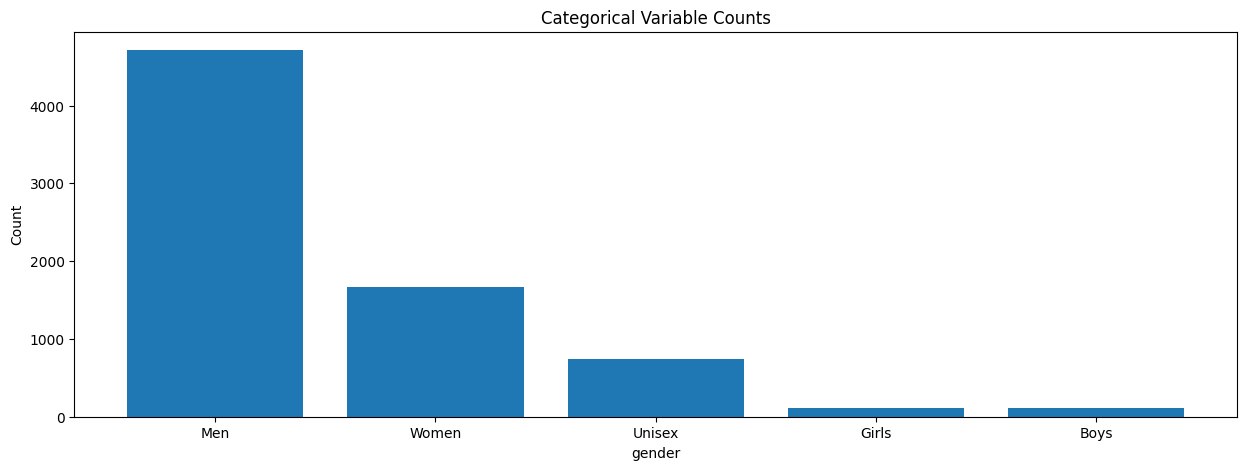

In [14]:
view_plot("gender")

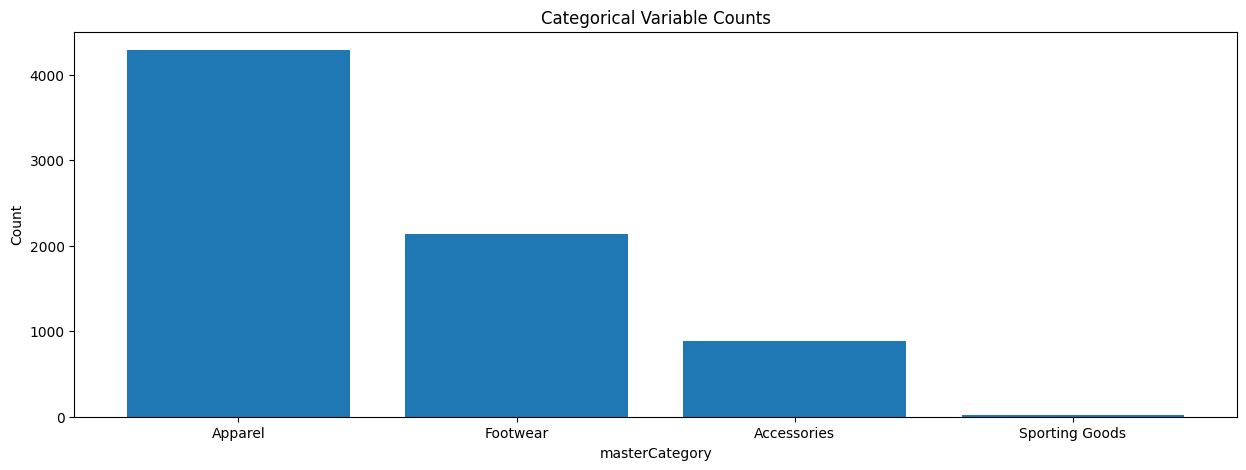

In [15]:
view_plot("masterCategory")

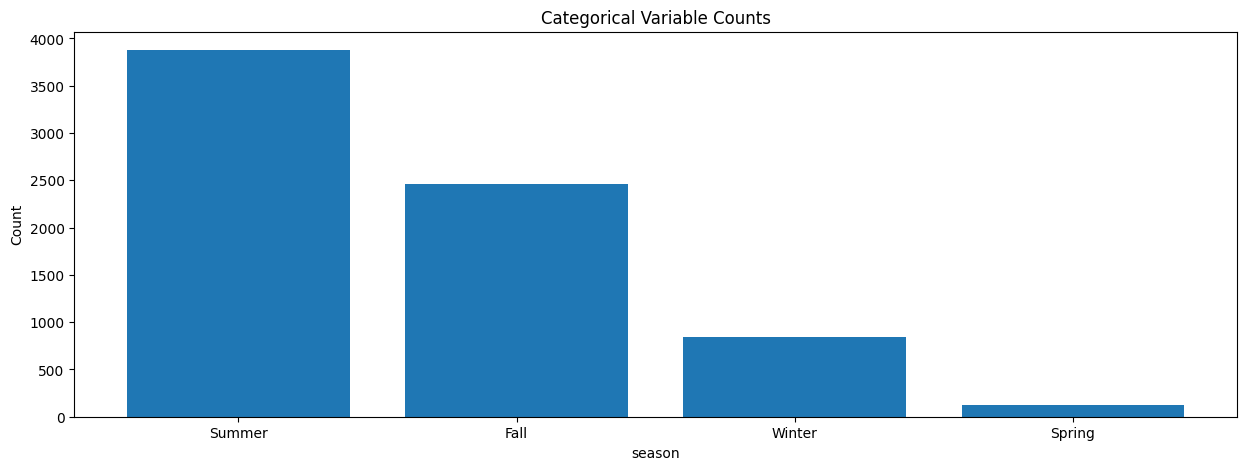

In [16]:
view_plot("season")

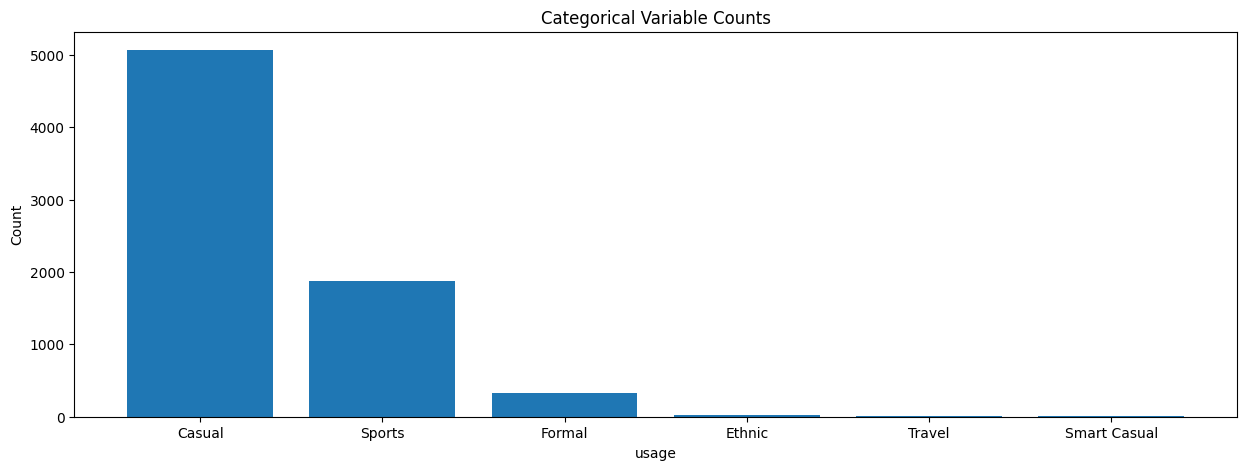

In [17]:
view_plot("usage")

In [18]:
catalog_df["subCategory"].value_counts(sort=True)

subCategory
Topwear                     3817
Shoes                       1740
Bags                         472
Bottomwear                   420
Sandal                       207
Flip Flops                   192
Watches                      106
Eyewear                       93
Socks                         72
Headwear                      48
Belts                         47
Dress                         44
Sports Equipment              20
Wallets                       15
Shoe Accessories              13
Water Bottle                   7
Accessories                    5
Apparel Set                    4
Sports Accessories             2
Innerwear                      1
Loungewear and Nightwear       1
Wristbands                     1
Name: count, dtype: int64

In [19]:
catalog_df["baseColour"].value_counts(sort=True)

baseColour
Black           1735
White           1298
Blue             938
Grey             559
Red              465
Brown            460
Green            426
Navy Blue        317
Purple           273
Pink             266
Yellow           188
Orange            86
Silver            60
Maroon            53
Beige             50
Cream             41
Peach             21
Olive             17
Multi             16
Gold              12
Steel             12
Tan                9
Charcoal           6
Burgundy           5
Teal               4
Mustard            3
Magenta            3
Grey Melange       2
Mauve              1
Khaki              1
Name: count, dtype: int64

In [20]:
catalog_df["articleType"].value_counts(sort=True)

articleType
Tshirts             2771
Sports Shoes         822
Casual Shoes         682
Shirts               622
Tops                 322
Backpacks            268
Flip Flops           192
Sandals              187
Handbags             152
Formal Shoes         152
Shorts               122
Track Pants          121
Watches              106
Sunglasses            93
Socks                 72
Jeans                 60
Jackets               50
Caps                  47
Belts                 46
Heels                 45
Dresses               44
Trousers              41
Flats                 39
Capris                37
Skirts                29
Duffel Bag            22
Sports Sandals        20
Wallets               17
Kurtas                17
Messenger Bag         14
Sweatshirts           13
Tunics                13
Basketballs           13
Shoe Accessories      12
Water Bottle          11
Swimwear               9
Footballs              7
Sweaters               6
Waist Pouch            5
Rucksacks    

## 5. Using UMAP for vectors visualization

**Dimensionality reduction** is a valuable tool utilized by machine learning practitioners to gain insights and interpret large, complex datasets that have a high number of dimensions.

Among the visualization techniques available, t-SNE is popular, but it may be challenging to use and may perform poorly with larger datasets. Recently, McInnes et al. developed a new method called **UMAP**, which offers several advantages over t-SNE, such as faster computation and better preservation of the data's global structure.

In [21]:
imagevector_array = np.array(catalog_df["imagevector"].to_list())

In [22]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_2d = UMAP(n_components=2, init="random", random_state=0)
proj_2d = umap_2d.fit_transform(imagevector_array)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...
Done
Elapsed time: 00:00:26.940113


In [23]:
def plot_2D_umap(variable):
    """
    Plot 2D Umap
    """
    fig_2d = px.scatter(
        proj_2d,
        x=0,
        y=1,
        color=catalog_df[variable].tolist(),
        labels={"color": variable},
        custom_data=[catalog_df["imagefile"].tolist()],
        title="Images Vectors Embeddings UMAP Projections",
        height=640,
    )

    fig_2d.update_traces(marker_size=3, hovertemplate="%{customdata}")
    fig_2d.show()

In [24]:
plot_2D_umap("masterCategory")

In [25]:
plot_2D_umap("season")

In [26]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_3d = UMAP(n_components=3, init="random", random_state=0)
proj_3d = umap_3d.fit_transform(imagevector_array)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...
Done
Elapsed time: 00:00:10.715189


In [27]:
def plot_3D_umap(variable):
    """
    Plot 3D Umap
    """
    fig_3d = px.scatter_3d(
        proj_3d,
        x=0,
        y=1,
        z=2,
        color=catalog_df[variable].tolist(),
        labels={"color": variable},
        custom_data=[catalog_df["imagefile"].tolist()],
        title="Images Vectors Embeddings UMAP Projections",
        height=860,
    )

    fig_3d.update_traces(marker_size=2, hovertemplate="%{customdata}")
    fig_3d.show()

In [28]:
plot_3D_umap("masterCategory")

## We can take 2 images that are close from the UMAP plot

In [29]:
def view_image(image_file):
    """
    View image from a blob storage
    """
    blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
    container_client = blob_service_client.get_container_client(container_name)
    blob_client = container_client.get_blob_client(image_file)
    blob_image = container_client.get_blob_client(image_file).download_blob().readall()

    # Create an in-memory stream
    image_stream = io.BytesIO(blob_image)

    # Open and display the image
    print("Image:", image_file)
    image = Image.open(image_stream)
    image.thumbnail((512, 512), Image.LANCZOS)
    display(image)

In [30]:
imagefile1 = "fashion/0643833004.jpg"
imagefile2 = "fashion/0643833001.jpg"

Image: fashion/0643833004.jpg


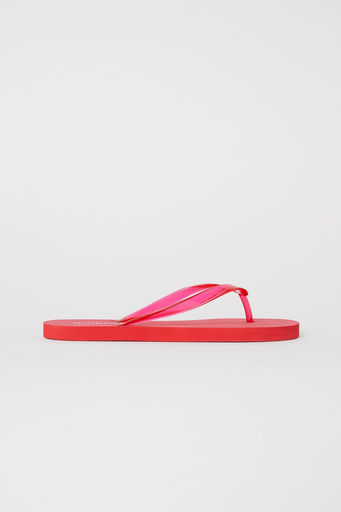

In [31]:
view_image(imagefile1)

Image: fashion/0643833001.jpg


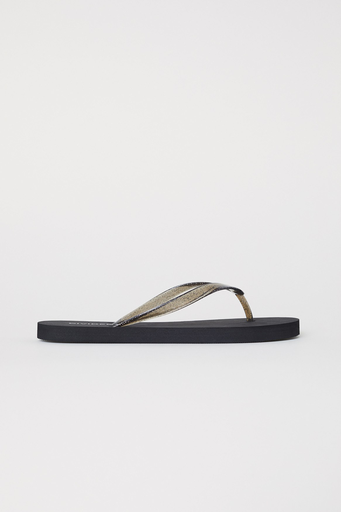

In [32]:
view_image(imagefile2)

> So they are quite similar

> End